In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import context_inference
from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

In [9]:
blue = '#1F449C'
orange = '#E57A77'

plt.rc('font', size=18)      
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=18)   
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18)    
plt.rc('legend', fontsize=15)    
plt.rc('figure', titlesize=18)

## Model

In [2]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10]*nBins,[50]*nBins,[55]*nBins,[45]*nBins)

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}

obs = model.expected_actualdata([0., 2.])

prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [19]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [3]:
expData_op = make_op.make_op(model)

### Prior and Posterior Predictives

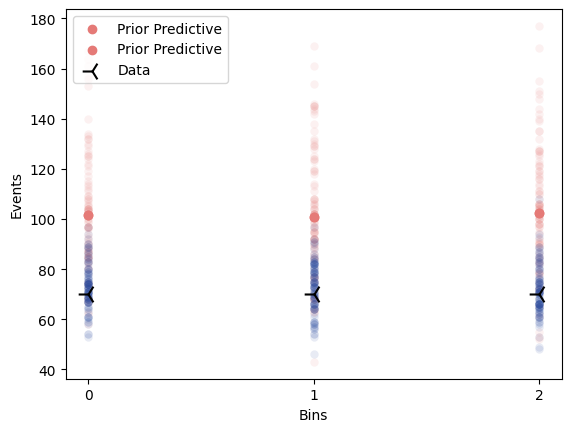

In [4]:
plotting.prior_posterior_predictives(model=model, observed=[70, 70, 70], post_pred=post_pred, prior_pred=prior_pred)

### Corner Plots

In [ ]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(10_000, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

In [ ]:
my_range = [(-5, 5), (0, 16)]
my_bins = [25, 25]

a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, title_fmt=None, color=orange, labels=['', ''], bins=my_bins, range=my_range)
corner.corner(post_data.posterior, quantiles=[0.5], color = blue, truths=[0., 2.], truth_color='grey', bins=[25, 25], fig=a, labels=['Correlated background', 'Signal strength'], range=my_range)
a.suptitle('Prior and Posterior Parameter Distributions')

In [ ]:
yrange = (0, 13_000)

fig, axs = plt.subplots(2, 2, figsize=(5.5, 5.8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.suptitle('Prior and Posterior Parameter Distributions')
axs[0, 1].remove()

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[1, 1]

# Normals Histogram
ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange)
_, bins, _ = ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax1.hist(post_data.posterior.Normals[0], bins=bins, histtype='step', color=blue)
ax1.set_ylim(130)
ax1.vlines(0, 0, 13_000, color='grey')
ax1.set_yticks([])


# Scatter Plot
ax2.scatter(prior_pred.prior.Normals[0], prior_pred.prior.Unconstrained[0], alpha=0.6, s=0.04, color=orange)
ax2.scatter(post_data.posterior.Normals[0], post_data.posterior.Unconstrained[0], alpha=0.6, s=0.04, color=blue)
ax2.vlines(0, -2, 30, color='black')
ax2.set_ylim(-2, 20)
ax2.hlines(2, -6, 6, color='black')
ax2.set_xlim(-4, 4)
ax2.scatter(0, 2, color='black')
ax2.set_xlabel('Background')
ax2.set_ylabel('Signal strength')

# Unconstrained Histogram
ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, label='Prior')
_, bins, _ = ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax3.hist(post_data.posterior.Unconstrained[0], bins=bins, histtype='step', color=blue, label='Posterior')
ax3.set_yticks([])
ax3.set_xticks([0, 10, 20])
ax3.set_ylim(30)
ax3.set_xlim(0)
ax3.vlines(2, 0, 13_000, color='black', label='Truth')
ax3.set_xlabel('Signal strength')
plt.rc('legend', fontsize=14)  
ax3.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

  

### Calibration

In [32]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(3000)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

Sampling: [Expected_Data, Normals, Unconstrained]


In [33]:
prior_Normals

array([-0.39718915,  0.13769235,  2.49061602, ..., -1.29629507,
        2.30989499,  0.744931  ])

In [34]:
post_Normals, post_Unconstrained, post_data = plotting.calibration(prepared_model, prior_pred)

Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


In [ ]:
with open('post_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Normals.tolist(), filehandle)
with open('post_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Unconstrained.tolist(), filehandle)

with open('prior_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Normals.tolist(), filehandle)
with open('prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Unconstrained.tolist(), filehandle)

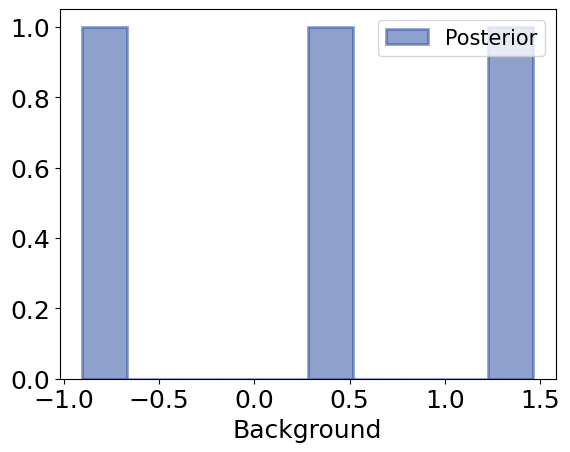

In [18]:
# Plot Normals
plt.hist(prior_Normals, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Normals, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Normals, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Background')

plt.legend()


In [ ]:

    
# Plot Unconstrained 
plt.hist(prior_Unconstrained, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')

plt.legend()

plt.show()